# Amazon review spam detection

# Load data utilizing Apache SPARK 

In [2]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.6 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 15.3 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285411 sha256=35513e11421f27366edb3c4ba30b1edbb6a8818ee246178f8c41ab857362f553
  Stored in directory: /root/.cache/pip/wheels/b7/8e/8f/ba5d017af5f502964eb1358e1d496a8519de1645936b01810e
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.5
    Uninstalling py4j-0.10.9.5:
      Successfully uninstalled py4j-0.10.9.5


In [3]:


from pyspark.sql import SparkSession

# SparkSession
spark = SparkSession.builder \
            .appName('Amazon Review Spam Detection_AMX_APEX') \
            .config("spark.driver.memory", "10g") \
            .config("spark.executor.memoryOverhead", "10g") \
            .config("spark.driver.maxResultSize", "10g") \
            .getOrCreate()

df = spark.read.json("/kaggle/input/amazon-product-review-spam-and-non-spam/Electronics/Electronics.json")

df.show()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/28 02:02:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/opt/conda/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


+--------------------+----------+-----------+-----+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|                 _id|      asin|   category|class| helpful|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|
+--------------------+----------+-----------+-----+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|{5a13242d741a2384...|0439886341|Electronics|  0.0|  [1, 1]|    3.0|Some of the funct...|07 22, 2013|A2WNBOD3WNDNKT|                 JAL|       Disappointing|    1374451200|
|{5a13242d741a2384...|0132793040|Electronics|  1.0|  [1, 1]|    5.0|Corey Barker does...|04 13, 2013| AKM1MP6P0OYPR|Vicki Gibson "momo4"|       Very thorough|    1365811200|
|{5a13242d741a2384...|0321732944|Electronics|  1.0|  [0, 0]|    5.0|While many beginn...| 07 1, 2012|A2CX7LUOHB2NDG|              

In [5]:
spark.conf.get("spark.driver.maxResultSize")

'10g'

# **Imports**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from pyspark.sql.functions import from_unixtime, year, month, count, when

from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords


from pyspark.sql.functions import avg, count, when

import seaborn as sns

from pyspark.sql import functions as F

from pyspark.sql.functions import isnan, when, col

from pyspark.sql.window import Window
from pyspark.ml.feature import Bucketizer

from pyspark.sql.functions import dayofweek

from pyspark.sql.functions import lower, regexp_replace

from pyspark.sql.functions import length

from pyspark.sql.functions import size, split, udf
from pyspark.sql.types import IntegerType

from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf

# Data preprocessing

* ## Understanding the datatypes for each vector

In [6]:
df.printSchema()


root
 |-- _id: struct (nullable = true)
 |    |-- $oid: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- category: string (nullable = true)
 |-- class: double (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)



In [7]:
distinct_labels = df.select('class').distinct().rdd.flatMap(lambda x: x).collect()

# for each unique 'label', show a few records
for label in distinct_labels:
    df.filter(df['class'] == label).show(n=5)  

+--------------------+----------+-----------+-----+-------+-------+--------------------+-----------+--------------+------------------+--------------------+--------------+
|                 _id|      asin|   category|class|helpful|overall|          reviewText| reviewTime|    reviewerID|      reviewerName|             summary|unixReviewTime|
+--------------------+----------+-----------+-----+-------+-------+--------------------+-----------+--------------+------------------+--------------------+--------------+
|{5a13242d741a2384...|0439886341|Electronics|  0.0| [1, 1]|    3.0|Some of the funct...|07 22, 2013|A2WNBOD3WNDNKT|               JAL|       Disappointing|    1374451200|
|{5a13242d741a2384...|0439886341|Electronics|  0.0| [1, 1]|    1.0|It never worked. ...|04 29, 2013|A2NWSAGRHCP8N5|       bowmans2007| absolutely horrible|    1367193600|
|{5a13242d741a2384...|0439886341|Electronics|  0.0| [4, 4]|    1.0|Do not waste your...|04 18, 2012|A1GI0U4ZRJA8WN|         Truthfull|TERRIBLE DO

# Phase1: Data Cleaning

## I. Removing special characters from id

In [8]:
cleaned_df = df.withColumn("_id", col("_id").getField("$oid"))
cleaned_df = cleaned_df.withColumn("_id", regexp_replace(col("_id"), "[{}]", ""))

cleaned_df.show()


+--------------------+----------+-----------+-----+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|                 _id|      asin|   category|class| helpful|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|
+--------------------+----------+-----------+-----+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|5a13242d741a2384e...|0439886341|Electronics|  0.0|  [1, 1]|    3.0|Some of the funct...|07 22, 2013|A2WNBOD3WNDNKT|                 JAL|       Disappointing|    1374451200|
|5a13242d741a2384e...|0132793040|Electronics|  1.0|  [1, 1]|    5.0|Corey Barker does...|04 13, 2013| AKM1MP6P0OYPR|Vicki Gibson "momo4"|       Very thorough|    1365811200|
|5a13242d741a2384e...|0321732944|Electronics|  1.0|  [0, 0]|    5.0|While many beginn...| 07 1, 2012|A2CX7LUOHB2NDG|              

## II. Dropping unnecessary columns

In [9]:
cleaned_df = cleaned_df.drop( 'category') #,'asin' , 'reviewerID', 'reviewerName') 
cleaned_df.show()

+--------------------+----------+-----+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|                 _id|      asin|class| helpful|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|
+--------------------+----------+-----+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|5a13242d741a2384e...|0439886341|  0.0|  [1, 1]|    3.0|Some of the funct...|07 22, 2013|A2WNBOD3WNDNKT|                 JAL|       Disappointing|    1374451200|
|5a13242d741a2384e...|0132793040|  1.0|  [1, 1]|    5.0|Corey Barker does...|04 13, 2013| AKM1MP6P0OYPR|Vicki Gibson "momo4"|       Very thorough|    1365811200|
|5a13242d741a2384e...|0321732944|  1.0|  [0, 0]|    5.0|While many beginn...| 07 1, 2012|A2CX7LUOHB2NDG|              Bernie|Adobe Photoshop C...|    1341100800|
|5a13242d741a2384e...|043988

## III. Renaming few Columns for QoL

In [10]:
cleaned_df = cleaned_df.withColumnRenamed("overall", "productRating")\
            .withColumnRenamed("_id", "id")
             


In [11]:
cleaned_df.show()

+--------------------+----------+-----+--------+-------------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|                  id|      asin|class| helpful|productRating|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|
+--------------------+----------+-----+--------+-------------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|5a13242d741a2384e...|0439886341|  0.0|  [1, 1]|          3.0|Some of the funct...|07 22, 2013|A2WNBOD3WNDNKT|                 JAL|       Disappointing|    1374451200|
|5a13242d741a2384e...|0132793040|  1.0|  [1, 1]|          5.0|Corey Barker does...|04 13, 2013| AKM1MP6P0OYPR|Vicki Gibson "momo4"|       Very thorough|    1365811200|
|5a13242d741a2384e...|0321732944|  1.0|  [0, 0]|          5.0|While many beginn...| 07 1, 2012|A2CX7LUOHB2NDG|              Bernie|Adobe Photoshop C...|    1341

## IV. Placing the number of votes received as a metric from Helpful

In [12]:
cleaned_df = cleaned_df.withColumn('reviewUpvotes', col('helpful')[0])
cleaned_df.show()

+--------------------+----------+-----+--------+-------------+--------------------+-----------+--------------+--------------------+--------------------+--------------+-------------+
|                  id|      asin|class| helpful|productRating|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|reviewUpvotes|
+--------------------+----------+-----+--------+-------------+--------------------+-----------+--------------+--------------------+--------------------+--------------+-------------+
|5a13242d741a2384e...|0439886341|  0.0|  [1, 1]|          3.0|Some of the funct...|07 22, 2013|A2WNBOD3WNDNKT|                 JAL|       Disappointing|    1374451200|            1|
|5a13242d741a2384e...|0132793040|  1.0|  [1, 1]|          5.0|Corey Barker does...|04 13, 2013| AKM1MP6P0OYPR|Vicki Gibson "momo4"|       Very thorough|    1365811200|            1|
|5a13242d741a2384e...|0321732944|  1.0|  [0, 0]|          5.0|While many beginn...| 07 1, 

## V. Modifying the originally 'helpful' column to a float value showcasing the no. of people who found it helpful among the total people that viewed it

In [13]:
def helpful_ratio(helpful):
    try:
        return (helpful[0] / helpful[1])*100
    except ZeroDivisionError:
        return 0.0 
    except:
        return None


ratio_udf = udf(helpful_ratio, FloatType())

cleaned_df =  cleaned_df.withColumn('helpful', ratio_udf(col('helpful')))



In [14]:
cleaned_df =cleaned_df.withColumnRenamed("helpful", "helpfulTotalRatio")

In [15]:
cleaned_df.columns

['id',
 'asin',
 'class',
 'helpfulTotalRatio',
 'productRating',
 'reviewText',
 'reviewTime',
 'reviewerID',
 'reviewerName',
 'summary',
 'unixReviewTime',
 'reviewUpvotes']

## VI. No. of uppercase words in the review

In [16]:
def count_uppercase_words(text):
    words = text.split()
    uppercase_words = [word for word in words if word.isupper()]
    return len(uppercase_words)

count_uppercase_words_udf = udf(count_uppercase_words, IntegerType())

cleaned_df = cleaned_df.withColumn('num_uppercase_words', count_uppercase_words_udf(col('reviewText')))

## VII.  No. of Exclamation marks

In [17]:
cleaned_df = cleaned_df.withColumn('num_exclamation_marks', (length(col('reviewText')) - length(regexp_replace(col('reviewText'), '!', ''))))

## VIII. Removing special characters and converting them to just lowercase

> 1. from reviewText

In [18]:
cleaned_df = cleaned_df.withColumn("reviewText", lower(col("reviewText")))\
                 .withColumn("reviewText", regexp_replace(col("reviewText"), "[^\w\s]", ""))


> 2. from Summary

In [19]:

cleaned_df = cleaned_df.withColumn("summary", lower(col("summary")))\
                 .withColumn("summary", regexp_replace(col("summary"), "[^\w\s]", ""))


In [20]:
cleaned_df.show()

+--------------------+----------+-----+-----------------+-------------+--------------------+-----------+--------------+--------------------+--------------------+--------------+-------------+-------------------+---------------------+
|                  id|      asin|class|helpfulTotalRatio|productRating|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|reviewUpvotes|num_uppercase_words|num_exclamation_marks|
+--------------------+----------+-----+-----------------+-------------+--------------------+-----------+--------------+--------------------+--------------------+--------------+-------------+-------------------+---------------------+
|5a13242d741a2384e...|0439886341|  0.0|            100.0|          3.0|some of the funct...|07 22, 2013|A2WNBOD3WNDNKT|                 JAL|       disappointing|    1374451200|            1|                  0|                    0|
|5a13242d741a2384e...|0132793040|  1.0|            100.0|          5

## IX. Evaluating Review and Summary Length 

In [21]:
cleaned_df = cleaned_df.withColumn('reviewLength', length(cleaned_df['reviewText']))
cleaned_df = cleaned_df.withColumn('summaryLength', length(cleaned_df['summary']))
cleaned_df.show()

+--------------------+----------+-----+-----------------+-------------+--------------------+-----------+--------------+--------------------+--------------------+--------------+-------------+-------------------+---------------------+------------+-------------+
|                  id|      asin|class|helpfulTotalRatio|productRating|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|reviewUpvotes|num_uppercase_words|num_exclamation_marks|reviewLength|summaryLength|
+--------------------+----------+-----+-----------------+-------------+--------------------+-----------+--------------+--------------------+--------------------+--------------+-------------+-------------------+---------------------+------------+-------------+
|5a13242d741a2384e...|0439886341|  0.0|            100.0|          3.0|some of the funct...|07 22, 2013|A2WNBOD3WNDNKT|                 JAL|       disappointing|    1374451200|            1|                  0|          

## X. Evaluating whether a review was posted on weekend or not

In [22]:

cleaned_df = cleaned_df.withColumn('reviewTime', col('reviewTime').cast('timestamp'))

cleaned_df = cleaned_df.withColumn('isWeekend', when(dayofweek(col('reviewTime')) > 5, 1).otherwise(0))


In [23]:
cleaned_df.show()

+--------------------+----------+-----+-----------------+-------------+--------------------+----------+--------------+--------------------+--------------------+--------------+-------------+-------------------+---------------------+------------+-------------+---------+
|                  id|      asin|class|helpfulTotalRatio|productRating|          reviewText|reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|reviewUpvotes|num_uppercase_words|num_exclamation_marks|reviewLength|summaryLength|isWeekend|
+--------------------+----------+-----+-----------------+-------------+--------------------+----------+--------------+--------------------+--------------------+--------------+-------------+-------------------+---------------------+------------+-------------+---------+
|5a13242d741a2384e...|0439886341|  0.0|            100.0|          3.0|some of the funct...|      null|A2WNBOD3WNDNKT|                 JAL|       disappointing|    1374451200|            1|    

## XI.    Creating Product Popularity from its review count,
## XII.   Calculating average rating as a metric,and
## XIII.  Bucketing The helpfulTotalRatio 

In [24]:
product_popularity_df = cleaned_df.groupBy('asin').agg(F.count('*').alias('productPopularity'))
cleaned_df = cleaned_df.join(product_popularity_df, on='asin', how='left')

product_avg_rating_df = cleaned_df.groupBy('asin').agg(F.avg('productRating').alias('avgProductRating'))
cleaned_df = cleaned_df.join(product_avg_rating_df, on='asin', how='left')

bucketizer = Bucketizer(splits=[0, 33.3, 66.6, 100], inputCol="helpfulTotalRatio", outputCol="helpfulRatioCategory")
cleaned_df = bucketizer.setHandleInvalid("keep").transform(cleaned_df)

cleaned_df = cleaned_df.withColumn("helpfulRatioCategory", 
                   F.when(F.col("helpfulRatioCategory") == 0, "Low")\
                    .when(F.col("helpfulRatioCategory") == 1, "Medium")\
                    .otherwise("High"))

cleaned_df = cleaned_df.withColumn('containsQuestion', (F.col('reviewText').like('%?%')).cast('integer'))


## Duplicate check for ID 

In [25]:

duplicates = cleaned_df.groupBy("id").count().filter(col("count") > 1)

duplicates.show()


+---+-----+
| id|count|
+---+-----+
+---+-----+



# **EDA**


## I) Correlation matrix among the given Features
**OBservation** : There is a strong correlation between the prediction class variable and the field productRating

In [103]:
sampled_df = cleaned_df.sample(False, 0.1)

sampled_df_pd = sampled_df.toPandas()

corr_matrix = sampled_df_pd.corr()




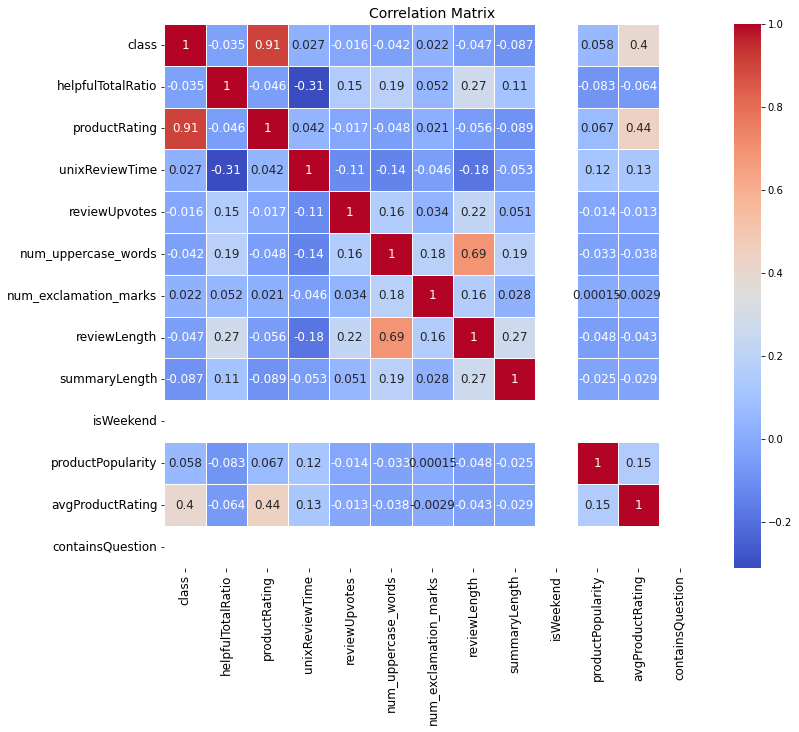

In [104]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm",linewidths=0.5, annot_kws={'fontsize': 12})
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title('Correlation Matrix', fontsize=14)

plt.show()

## Correlation matrix without the feature productRating

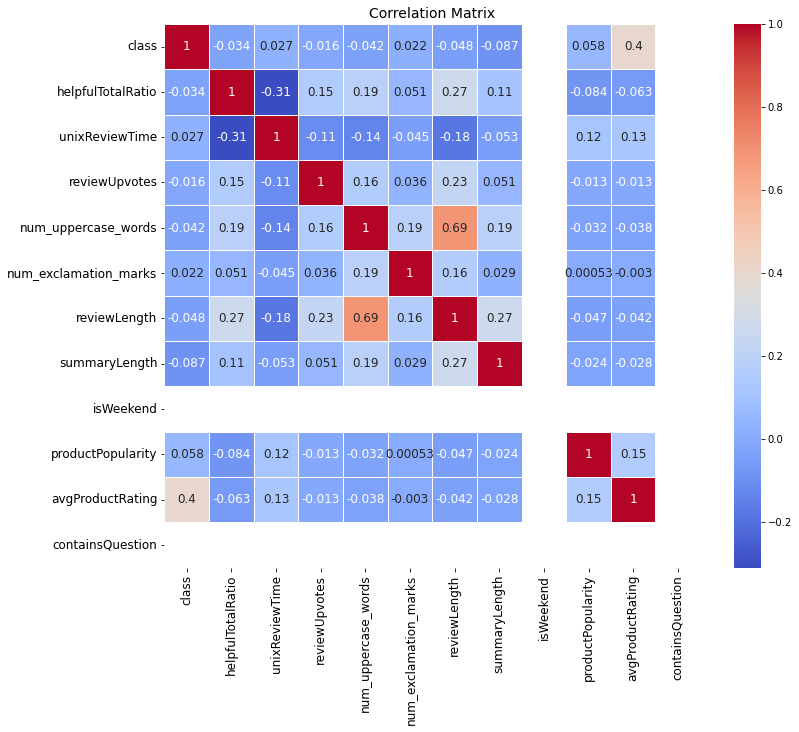

In [105]:
df_without_productRating = sampled_df.drop('productRating')

corr_matrix = df_without_productRating.toPandas().corr()

plt.figure(figsize=(12, 10))

sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5, annot_kws={'fontsize': 12})

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title('Correlation Matrix', fontsize=14)
plt.show()


**Observation** Since isWeekend & containsQuestion do not contain any useful data , we drop them

In [107]:
cleaned_df = cleaned_df.drop('isWeekend', 'containsQuestion')

## Correlation matirx for the numerical features

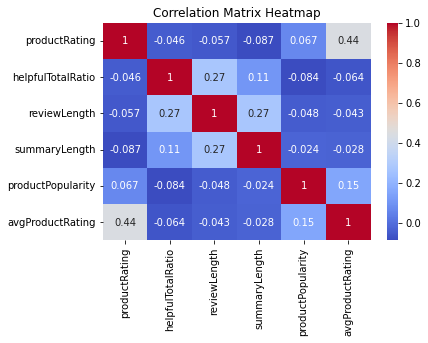

In [30]:
numerical_features = ['productRating', 'helpfulTotalRatio', 'reviewLength', 'summaryLength', 'productPopularity', 'avgProductRating']
correlation_df = cleaned_df.select(numerical_features).toPandas().corr()
sns.heatmap(correlation_df, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()


## II) Impact of Hyper exaggeration in classification of the reviews as spam
**Observation** : The number of uppercase words is very less and same is observed with the number of exclamation marks . use of them is very sparse but both of these are used more dominantly in spam reviews

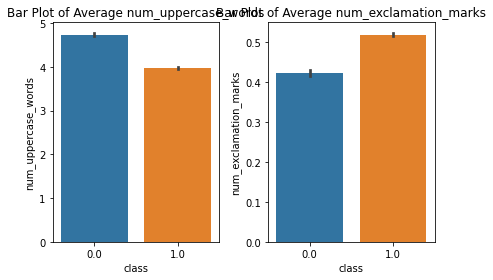

In [28]:
plt.subplot(1, 2, 1)
sns.barplot(data=pandas_df, x='class', y='num_uppercase_words')
plt.title('Bar Plot of Average num_uppercase_words')

plt.subplot(1, 2, 2)
sns.barplot(data=pandas_df, x='class', y='num_exclamation_marks')
plt.title('Bar Plot of Average num_exclamation_marks')

plt.tight_layout()
plt.show()

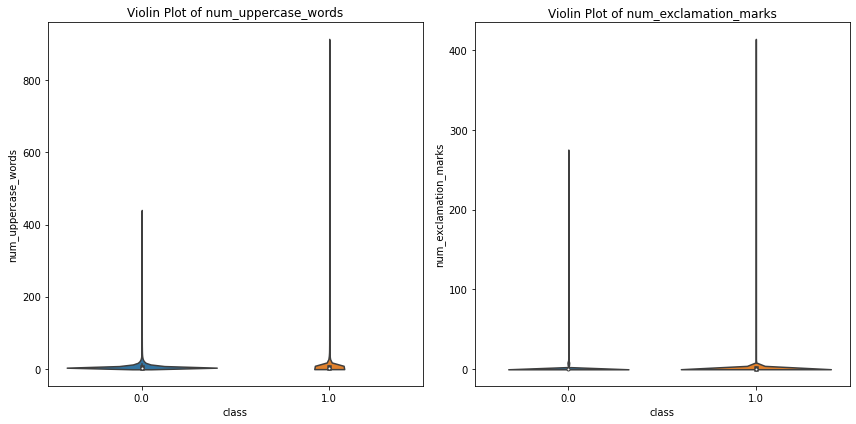

In [30]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.violinplot(data=pandas_df, x='class', y='num_uppercase_words')
plt.title('Violin Plot of num_uppercase_words')

plt.subplot(1, 2, 2)
sns.violinplot(data=pandas_df, x='class', y='num_exclamation_marks')
plt.title('Violin Plot of num_exclamation_marks')

plt.tight_layout()
plt.show()


## III) Violin graph explaining Density of Product Rating
**Observation** : The Median of the ratings is 5, with the interquartile range ranging from 4 to 5

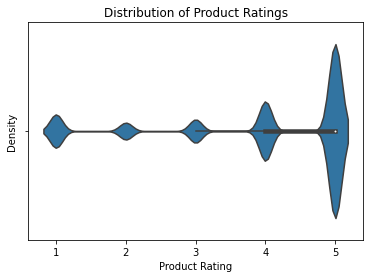

In [29]:
sampled_df = cleaned_df.sample(False, 0.1)

sampled_df_pd = sampled_df.toPandas()

sns.violinplot(data=sampled_df_pd, x="productRating")
plt.xlabel("Product Rating")
plt.ylabel("Density")
plt.title("Distribution of Product Ratings")
plt.show()


##  Plotting the distribution of the reviews
**Observation** : Most of the Reviews of rating 5 

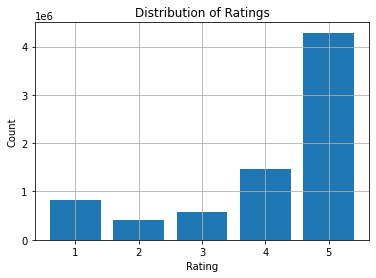

In [36]:
rating_counts = cleaned_df.groupBy("productRating").count().orderBy("productRating")

rating_counts_pd = rating_counts.toPandas()

plt.bar(rating_counts_pd["productRating"], rating_counts_pd["count"])
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of Ratings")
plt.grid(True)
plt.show()

## Plotting the spam reviews on top of the product rating distribution
**Observation** : All reviews rated 4 and 5 are classified as SPAM in this dataset

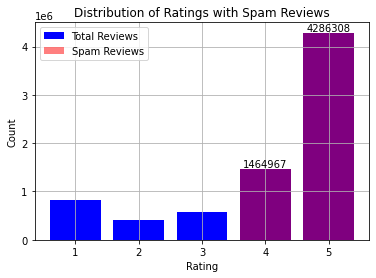

In [37]:
rating_counts = cleaned_df.groupBy("productRating").count().orderBy("productRating")
spam_counts = cleaned_df.filter(cleaned_df["class"] == 1).groupBy("productRating").count().orderBy("productRating")

rating_counts_pd = rating_counts.toPandas()
spam_counts_pd = spam_counts.toPandas()

plt.bar(rating_counts_pd["productRating"], rating_counts_pd["count"], color='blue', label='Total Reviews')
plt.bar(spam_counts_pd["productRating"], spam_counts_pd["count"], color='red', alpha=0.5, label='Spam Reviews')

for i in range(len(spam_counts_pd)):
    count = spam_counts_pd.loc[i, "count"]
    plt.annotate(str(count), xy=(spam_counts_pd.loc[i, "productRating"], count), ha='center', va='bottom')

plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of Ratings with Spam Reviews")
plt.legend()
plt.grid(True)
plt.show()


## IV) Calculate the percentage of missing values in each column
**Observation** : A small portion of the reviews are from Accounts with no name setup 

In [32]:

cleaned_df.select([(count(when(col(c).isNull(), c))/df.count()*100).alias(c) for c in cleaned_df.columns]).show()


+----+---+-----+-----------------+-------------+----------+----------+----------+------------------+-------+--------------+-------------+------------+-------------+---------+-----------------+----------------+--------------------+----------------+
|asin| id|class|helpfulTotalRatio|productRating|reviewText|reviewTime|reviewerID|      reviewerName|summary|unixReviewTime|reviewUpvotes|reviewLength|summaryLength|isWeekend|productPopularity|avgProductRating|helpfulRatioCategory|containsQuestion|
+----+---+-----+-----------------+-------------+----------+----------+----------+------------------+-------+--------------+-------------+------------+-------------+---------+-----------------+----------------+--------------------+----------------+
| 0.0|0.0|  0.0|              0.0|          0.0|       0.0|     100.0|       0.0|1.2688652708963848|    0.0|           0.0|          0.0|         0.0|          0.0|      0.0|              0.0|             0.0|                 0.0|             0.0|
+----+--

## V) Number of Reviews pasted by accounts with no names across ratings and their classification
**Observation** : These are in the same scale and equally distributed for each rating level with the whole dataset . These reviews and said reviewers are not nefarious.

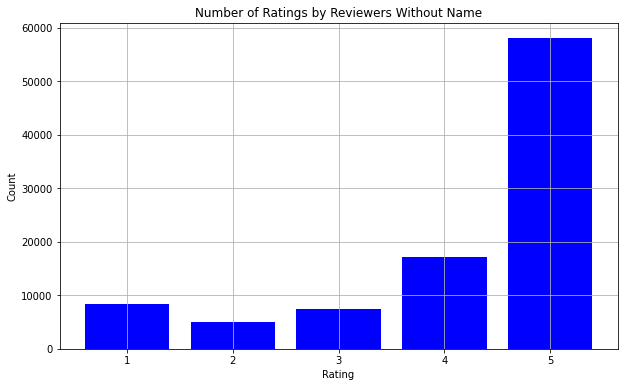

In [33]:

df_no_name = cleaned_df.filter(cleaned_df.reviewerName.isNull())

ratings_counts = df_no_name.groupBy("productRating").count().orderBy('productRating').toPandas()

plt.figure(figsize=(10, 6))
plt.bar(ratings_counts['productRating'], ratings_counts['count'], color='blue')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Number of Ratings by Reviewers Without Name')
plt.grid(True)
plt.show()

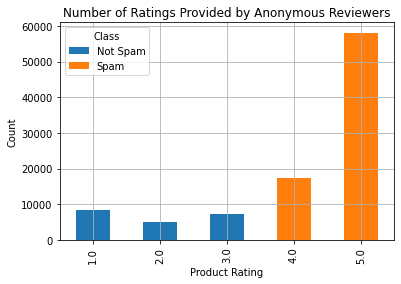

In [34]:
df_filtered = cleaned_df.filter((cleaned_df.reviewerName.isNull()) | (cleaned_df.reviewerName == ""))

df_count = df_filtered.groupBy("class", "productRating").count().orderBy("class", "productRating").toPandas()

pivot_df = df_count.pivot(index='productRating', columns='class', values='count')
pivot_df.columns = ['Not Spam', 'Spam']
pivot_df.fillna(0, inplace=True)

pivot_df.plot(kind='bar', stacked=True)
plt.title('Number of Ratings Provided by Anonymous Reviewers')
plt.xlabel('Product Rating')
plt.ylabel('Count')
plt.legend(title='Class')
plt.grid(True)
plt.show()


## VI) Pair Plot of ["helpfulTotalRatio", "productRating", "reviewUpvotes", "reviewLength"]
1. In the First Row, from the left
    a. The first graph showcases distribution between the number of reviews posted against helpfulness level of the review. We observe that a large number of reviews were not found to be helpful at all and a considerable portion to be found helpful by a majority of the viewers
    b. The second graph showcases distribution between productRating against against helpfulness level of the review

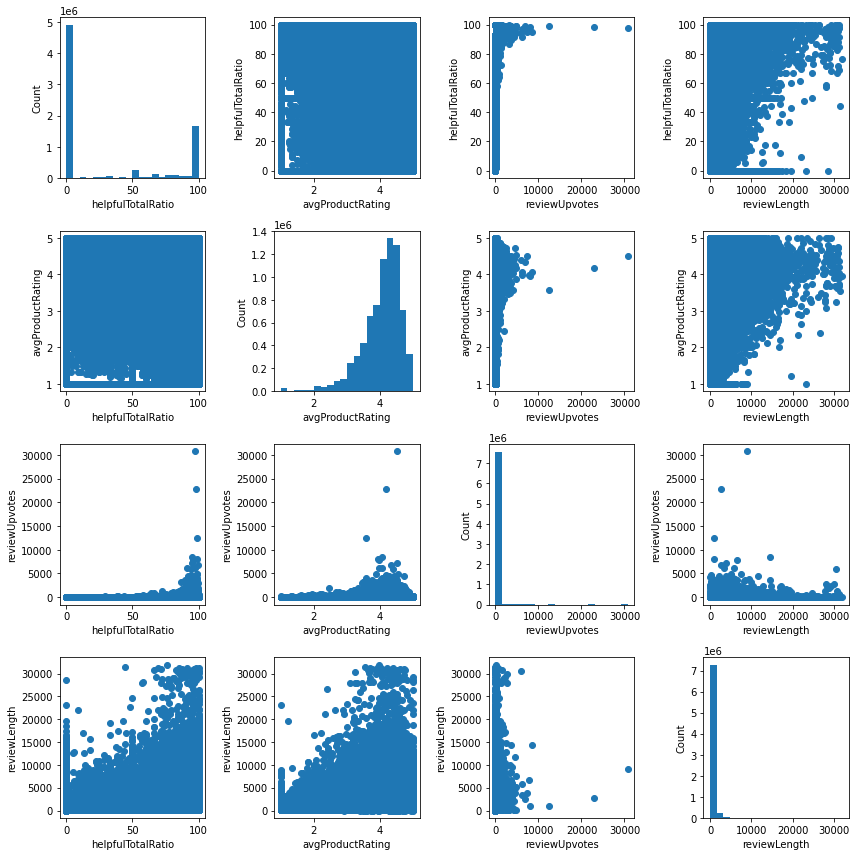

In [27]:
columns = ["helpfulTotalRatio", "avgProductRating", "reviewUpvotes", "reviewLength"]

df_pd = cleaned_df.select(columns).toPandas()

fig, axes = plt.subplots(len(columns), len(columns), figsize=(12, 12))

for i, col1 in enumerate(columns):
    for j, col2 in enumerate(columns):
        if i == j:
            axes[i, j].hist(df_pd[col1], bins=20)
            axes[i, j].set_xlabel(col1)
            axes[i, j].set_ylabel('Count')
        else:
            axes[i, j].scatter(df_pd[col2], df_pd[col1])
            axes[i, j].set_xlabel(col2)
            axes[i, j].set_ylabel(col1)

plt.tight_layout()
plt.show()


## VII) Identifying, for a reviewer , the no of reviews they have posted and the count of spam and non spam reviews they have

**Observation** : From the above analysis we can rule out that reviewers do not have any malicious intent and purely spam. 

In [32]:
df_with_spam = df.withColumn('spam_reviews', F.when(F.col('class') == 1, 1).otherwise(0))\
                 .withColumn('non_spam_reviews', F.when(F.col('class') == 0, 1).otherwise(0))

review_counts = df_with_spam.groupBy('reviewerID', 'reviewerName')\
                            .agg(F.count('*').alias('reviewer_count'),
                                 F.sum('spam_reviews').alias('spam_reviews'),
                                 F.sum('non_spam_reviews').alias('non_spam_reviews'))

ordered_review_counts = review_counts.orderBy(F.desc('reviewer_count'))

ordered_review_counts.show()

+--------------+--------------------+--------------+------------+----------------+
|    reviewerID|        reviewerName|reviewer_count|spam_reviews|non_spam_reviews|
+--------------+--------------------+--------------+------------+----------------+
| A5JLAU2ARJ0BO|Gadgester "No Tim...|           504|         350|             154|
|A3OXHLG6DIBRW8|       C. Hill "CFH"|           487|         457|              30|
|  ADLVFFE4VBT8|   A. Dent "Aragorn"|           486|         405|              81|
|  A6FIAB28IS79|        Samuel Chell|           420|         336|              84|
| A680RUE1FDO8B|    Jerry Saperstein|           397|         329|              68|
|A1ODOGXEYECQQ8|              Nuknuk|           368|         337|              31|
|A36K2N527TXXJN|    Dr. Bojan Tunguz|           310|         297|              13|
|A2AY4YUOX2N1BQ|              Ciaran|           306|         287|              19|
| AWPODHOB4GFWL|Martin A Hogan "M...|           301|         260|              41|
|A25

## Scatter plot showcasing Each reviewer's non-spam reviews for number of spam reviews posted
**Observation** : This trend shows that as the user writes more reviews, only a small portion of it are classified non-spam. No reviewer is perfect and they use the platofrm to showcase their creative writing with story-telling. 

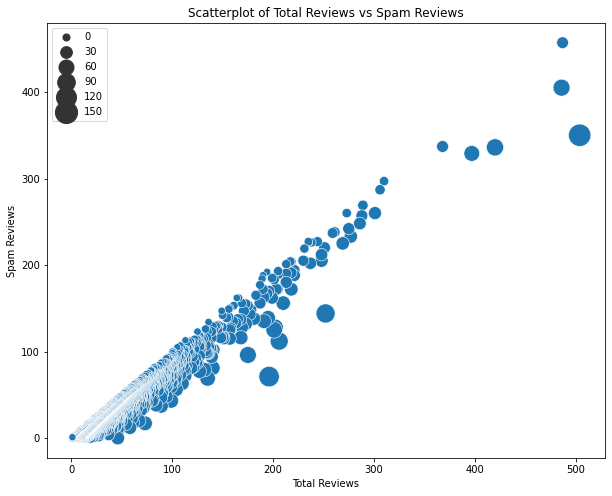

In [33]:
ordered_review_counts_pd = ordered_review_counts.toPandas()

plt.figure(figsize=(10,8))

scatter = sns.scatterplot(x='reviewer_count', y='spam_reviews', size='non_spam_reviews', 
                          sizes=(50, 500), data=ordered_review_counts_pd)

plt.xlabel("Total Reviews")
plt.ylabel("Spam Reviews")
plt.title("Scatterplot of Total Reviews vs Spam Reviews")

plt.legend()

plt.show()


## VIII) Are Reviewers intentionally spamming reviews ? 
**Observation** : In the current category, it appears that the reviewers do not always write spam reviews. They do contribute some significant amount of useful reviews

In [108]:
df_with_spam = cleaned_df.withColumn('spam_reviews', F.when(F.col('class') == 1, 1).otherwise(0))\
                 .withColumn('non_spam_reviews', F.when(F.col('class') == 0, 1).otherwise(0))

review_counts = df_with_spam.groupBy('reviewerID', 'reviewerName')\
                            .agg(F.count('*').alias('reviewer_count'),
                                 F.sum('spam_reviews').alias('spam_reviews'),
                                 F.sum('non_spam_reviews').alias('non_spam_reviews'))

ordered_review_counts = review_counts.orderBy(F.desc('reviewer_count'))

ordered_review_counts.show()


+--------------+--------------------+--------------+------------+----------------+
|    reviewerID|        reviewerName|reviewer_count|spam_reviews|non_spam_reviews|
+--------------+--------------------+--------------+------------+----------------+
| A5JLAU2ARJ0BO|Gadgester "No Tim...|           504|         350|             154|
|A3OXHLG6DIBRW8|       C. Hill "CFH"|           487|         457|              30|
|  ADLVFFE4VBT8|   A. Dent "Aragorn"|           486|         405|              81|
|  A6FIAB28IS79|        Samuel Chell|           420|         336|              84|
| A680RUE1FDO8B|    Jerry Saperstein|           397|         329|              68|
|A1ODOGXEYECQQ8|              Nuknuk|           368|         337|              31|
|A36K2N527TXXJN|    Dr. Bojan Tunguz|           310|         297|              13|
|A2AY4YUOX2N1BQ|              Ciaran|           306|         287|              19|
| AWPODHOB4GFWL|Martin A Hogan "M...|           301|         260|              41|
|A25

## IX) Understanding the amount of spam reviews out of the total reviews a product has recieved and averagre rating of the product from the reviews

**Observation** : From the analysis we can say that , though the reviews were spam, the large amounts of the users agree that the product is good. 

> This also raises the question of how a weighted average must be computed taking in usefulness of a review(helpful_votes) and the reviewer's rating of that product.

In [40]:
average_ratings = df.groupBy('asin').agg(
    avg('overall').alias('average_rating'),
    count('*').alias('total_reviews'),
    count(when(col('class') == 1, 1)).alias('spam_reviews')
)

sorted_ratings = average_ratings.orderBy('total_reviews', ascending=False)

sorted_ratings.show()

+----------+------------------+-------------+------------+
|      asin|    average_rating|total_reviews|spam_reviews|
+----------+------------------+-------------+------------+
|B0074BW614|4.5099181889499045|        17846|       15873|
|B00DR0PDNE| 3.973161973161973|        15873|       11451|
|B007WTAJTO| 4.447616987526137|        13869|       12085|
|B0019EHU8G|4.7654812235762245|        12063|       11473|
|B006GWO5WK| 4.351478494623656|        11904|        9933|
|B003ELYQGG| 4.419941711560541|        11323|        9732|
|B003ES5ZUU| 4.717169717961405|        10105|        9533|
|B007R5YDYA|   4.7006893713345|         9719|        9116|
|B00622AG6S|  4.44853399875234|         9618|        8407|
|B0002L5R78| 4.475370791382484|         9237|        8066|
|B008OHNZI0|  4.31543855615588|         8699|        7195|
|B003LR7ME6| 4.522186272244049|         8654|        7732|
|B000LRMS66| 4.766752276441746|         8566|        8210|
|B009SYZ8OC| 4.253016498399409|         8122|        647

## X) Identify how the helpfulTotalRation  aids to the classification of a review

**Observation** In this plotting of Reviews against helfulness of a rating, no helpful reviews and reviews that are found helpful by more that 90% of its viewers, both proportionally contain spam reviews. Indicating that helpful button is being used as a like button for the most of it

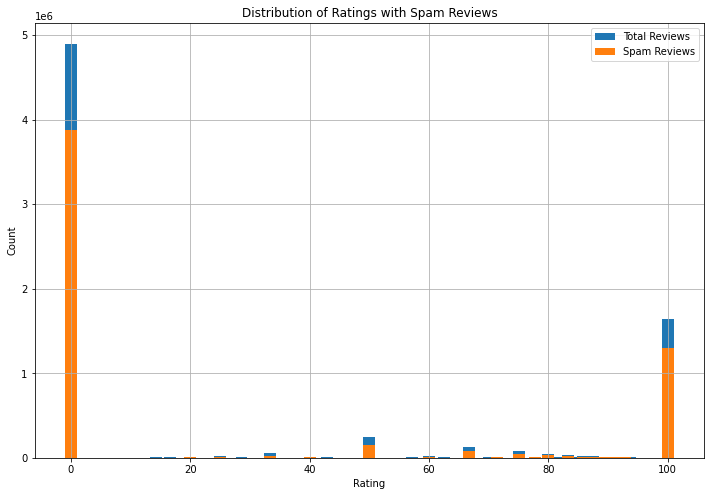

In [41]:
total_reviews = cleaned_df.groupBy("helpfulTotalRatio").count().orderBy("helpfulTotalRatio")
spam_reviews = cleaned_df.filter(cleaned_df["class"] == 1).groupBy("helpfulTotalRatio").count().orderBy("helpfulTotalRatio")

total_reviews_pd = total_reviews.toPandas()
spam_reviews_pd = spam_reviews.toPandas()

plt.figure(figsize=(12, 8))

plt.bar(total_reviews_pd["helpfulTotalRatio"], total_reviews_pd["count"], label="Total Reviews", width=2)
plt.bar(spam_reviews_pd["helpfulTotalRatio"], spam_reviews_pd["count"], label="Spam Reviews", width=2)

plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of Ratings with Spam Reviews")
plt.legend()
plt.grid(True)

plt.xticks(range(0, 101, 20)) 

plt.show()


## XI) Wordcloud of frequent words in spam and non spam reviews
**Observation** : The worcloud doesnt seem to show a specific trend on the words being used in reviews of these classes and are rather diverse. Thus we'll need further complex operations in order to accurately classify the review from being spam or not

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...            
[nltk_data]   Package stopwords is already up-to-date!


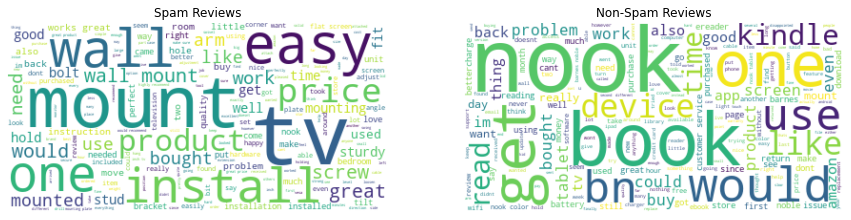

In [27]:
spam_reviews = cleaned_df.filter(cleaned_df['class'] == 1).select('reviewText').rdd.flatMap(lambda x: x).collect()
nonspam_reviews = cleaned_df.filter(cleaned_df['class'] == 0).select('reviewText').rdd.flatMap(lambda x: x).collect()

spam_reviews = spam_reviews[:1000]
nonspam_reviews = nonspam_reviews[:1000]

spam_text = ' '.join(spam_reviews)
nonspam_text = ' '.join(nonspam_reviews)

nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

spam_wordcloud = WordCloud(stopwords=stopwords, background_color='white').generate(spam_text)
nonspam_wordcloud = WordCloud(stopwords=stopwords, background_color='white').generate(nonspam_text)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))

ax1.imshow(spam_wordcloud, interpolation='bilinear')
ax1.set_title('Spam Reviews')
ax1.axis('off')

ax2.imshow(nonspam_wordcloud, interpolation='bilinear')
ax2.set_title('Non-Spam Reviews')
ax2.axis('off')

plt.show()


## 

## XII) Analysing the trend of number of reviews posted and how many of them were spam

**Observation** :We see that the number of non-spam reviews seem to be increasing steadily but the ration of spam to non-spam reducing , further emphasizing the need for a spam review detecction. Additionally Due to large amount of reviews being prroduced, we require AI generated summarized reviews containing all the core aspects of the non-spam reviews , important product details , etc. The viewers could also be benefitted by chatbots that could clarifu their assumptions and expectations of the products, improving customer experience

In [35]:
trend_df = cleaned_df.groupBy(year(from_unixtime('unixReviewTime')).alias('year'), 
                              month(from_unixtime('unixReviewTime')).alias('month')).agg(
    count('*').alias('total_reviews'),
    count(when(cleaned_df['class'] == 1, True)).alias('spam_reviews'),
    count(when(cleaned_df['class'] == 0, True)).alias('non_spam_reviews')
).orderBy('year', 'month')

trend_df.show()


+----+-----+-------------+------------+----------------+
|year|month|total_reviews|spam_reviews|non_spam_reviews|
+----+-----+-------------+------------+----------------+
|1998|   12|            4|           4|               0|
|1999|    5|            2|           2|               0|
|1999|    6|           16|          12|               4|
|1999|    7|           68|          52|              16|
|1999|    8|           40|          35|               5|
|1999|    9|           41|          36|               5|
|1999|   10|          161|         121|              40|
|1999|   11|          327|         259|              68|
|1999|   12|          522|         406|             116|
|2000|    1|          477|         376|             101|
|2000|    2|          350|         268|              82|
|2000|    3|          389|         305|              84|
|2000|    4|          448|         360|              88|
|2000|    5|          691|         560|             131|
|2000|    6|         1196|     

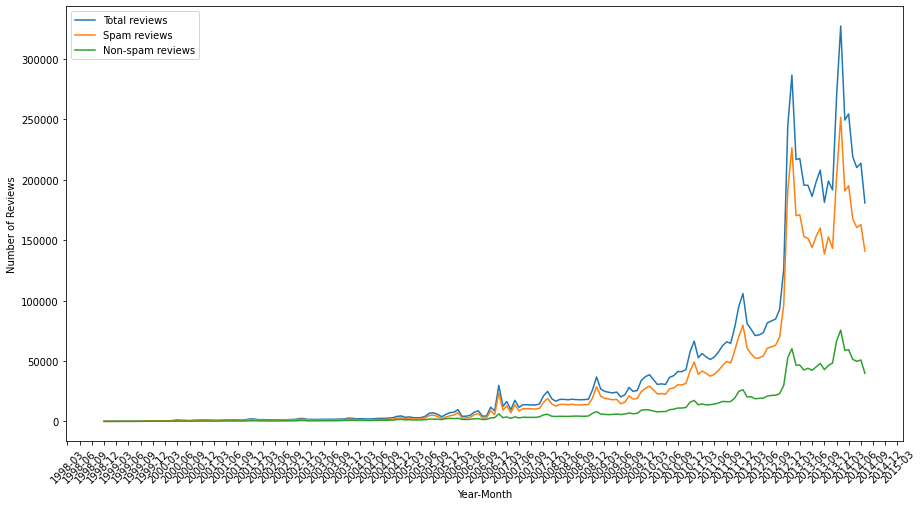

In [36]:
trend_pd = trend_df.toPandas()

trend_pd['date'] = pd.to_datetime(trend_pd[['year', 'month']].assign(day=1))

trend_pd.sort_values('date', inplace=True)

fig, ax = plt.subplots(figsize=(15, 8))  

ax.plot(trend_pd['date'], trend_pd['total_reviews'], label='Total reviews')
ax.plot(trend_pd['date'], trend_pd['spam_reviews'], label='Spam reviews')
ax.plot(trend_pd['date'], trend_pd['non_spam_reviews'], label='Non-spam reviews')

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  

plt.xticks(rotation=45)

plt.xlabel('Year-Month')
plt.ylabel('Number of Reviews')
plt.legend()

plt.show()
